In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn import preprocessing as pp
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split as tts
from sklearn.cluster import KMeans,AgglomerativeClustering
from tensorflow import keras
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from scipy.cluster.hierarchy import dendrogram,linkage

In [2]:
def haversine(coord1, coord2):
    R = 6371
    lat1, lon1 = map(float, coord1.strip("()").split(","))
    lat2, lon2 = map(float, coord2.strip("()").split(","))
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

In [3]:
df = pd.read_csv('Food_Delivery_Time_Prediction.csv')
df = df.dropna()
df = pd.get_dummies(df,columns=['Weather_Conditions','Traffic_Conditions','Vehicle_Type','Order_Priority'])
df['GDistance'] = df.apply(lambda row: haversine(row['Customer_Location'], row['Restaurant_Location']),axis=1)

df['Delivery_Status'] = df['Delivery_Time'].apply(lambda x: 'Fast' if x <= df['Delivery_Time'].quantile(0.75) else 'Delayed')
df['Delivery_Status'] = df['Delivery_Status'].map({'Fast': 0, 'Delayed': 1})

rush_hours = ['Morning', 'Evening']
df['Is_Rush_Hour'] = df['Order_Time'].isin(rush_hours).astype(bool)

scaler = pp.StandardScaler()
columnsToScale = ['Distance','GDistance','Delivery_Time','Order_Cost','Delivery_Person_Experience']
df[columnsToScale] = scaler.fit_transform(df[columnsToScale])
df.head()

,Order_ID,Customer_Location,Restaurant_Location,Distance,Delivery_Person_Experience,Order_Time,Restaurant_Rating,Customer_Rating,Delivery_Time,Order_Cost,...,Traffic_Conditions_Medium,Vehicle_Type_Bicycle,Vehicle_Type_Bike,Vehicle_Type_Car,Order_Priority_High,Order_Priority_Low,Order_Priority_Medium,GDistance,Delivery_Status,Is_Rush_Hour
0,ORD0001,"(17.030479, 79.743077)","(12.358515, 85.100083)",-1.454738,-0.456512,Afternoon,4.1,3.0,-1.487932,0.501852,...,True,False,False,True,False,False,True,0.641395,0,False
1,ORD0002,"(15.398319, 86.639122)","(14.174874, 77.025606)",1.439192,1.004325,Night,4.5,4.2,-0.264987,-1.634294,...,True,False,False,True,False,True,False,1.632526,0,False
2,ORD0003,"(15.687342, 83.888808)","(19.594748, 82.048482)",-0.666417,1.369535,Night,3.3,3.4,-0.741529,1.092646,...,True,False,True,False,True,False,False,-0.471227,0,False
3,ORD0004,"(20.415599, 78.046984)","(16.915906, 78.278698)",0.335835,-1.186930,Evening,3.2,3.7,1.382411,-0.923323,...,False,False,True,False,False,False,True,-0.791930,1,True
4,ORD0005,"(14.786904, 78.706532)","(15.206038, 86.203182)",-0.700119,0.273907,Night,3.5,2.8,-1.280915,-0.779755,...,False,False,True,False,False,True,False,0.756045,0,False


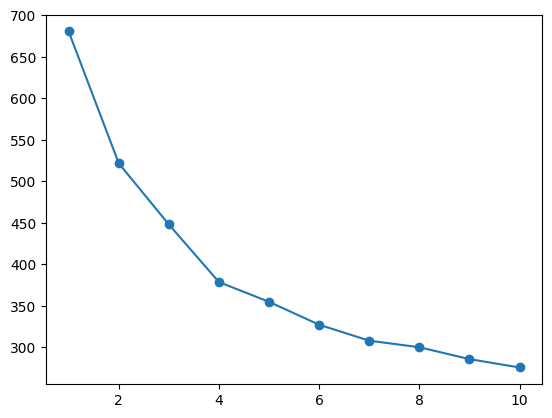

In [4]:
x = df[['Delivery_Time','GDistance','Weather_Conditions_Sunny','Weather_Conditions_Rainy','Weather_Conditions_Cloudy','Weather_Conditions_Snowy','Traffic_Conditions_High','Traffic_Conditions_Low','Traffic_Conditions_Medium']]

inertias = []
for i in range(1,11):
  kmeans = KMeans(n_clusters=i,random_state=42)
  kmeans.fit(x)
  inertias.append(kmeans.inertia_)

plt.plot(range(1,11),inertias,marker='o')
plt.show()

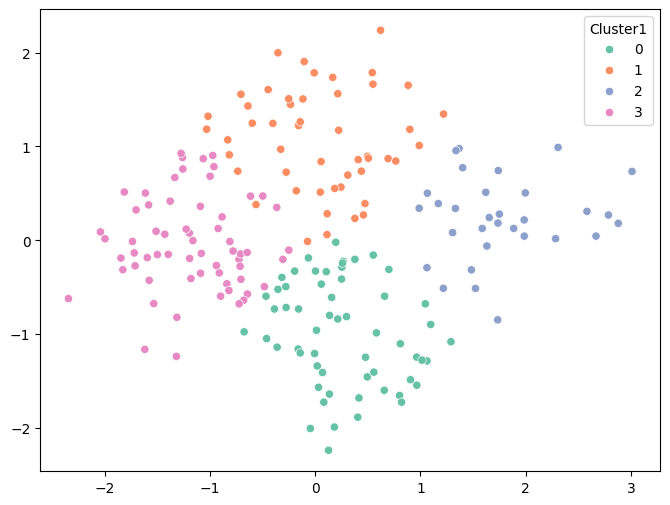

          Distance  Delivery_Person_Experience  Restaurant_Rating  \
Cluster1                                                            
0         0.146864                    0.047225           3.781034   
1        -0.122499                   -0.039130           3.655102   
2         0.039376                   -0.067740           3.864516   
3        -0.060263                    0.020617           3.701613   

          Customer_Rating  Delivery_Time  Order_Cost  Tip_Amount  \
Cluster1                                                           
0                3.627586      -0.882671   -0.012343   52.591034   
1                3.657143       0.724756    0.260145   49.566531   
2                3.719355      -1.079265   -0.081823   39.668710   
3                3.748387       0.792566   -0.153141   42.170323   

          Weather_Conditions_Cloudy  Weather_Conditions_Rainy  \
Cluster1                                                        
0                          0.241379           

In [5]:
# Looks 4 is best point
kmeans = KMeans(n_clusters=4,random_state=42)
df['Cluster1'] = kmeans.fit_predict(x)

pca = PCA(n_components=2)
x = pca.fit_transform(x)
plt.figure(figsize=(8,6))
sb.scatterplot(x=x[:,0],y=x[:,1],hue=df['Cluster1'],palette='Set2')
plt.show()
cluster_summary = df.groupby('Cluster1').mean(numeric_only=True)
print(cluster_summary)

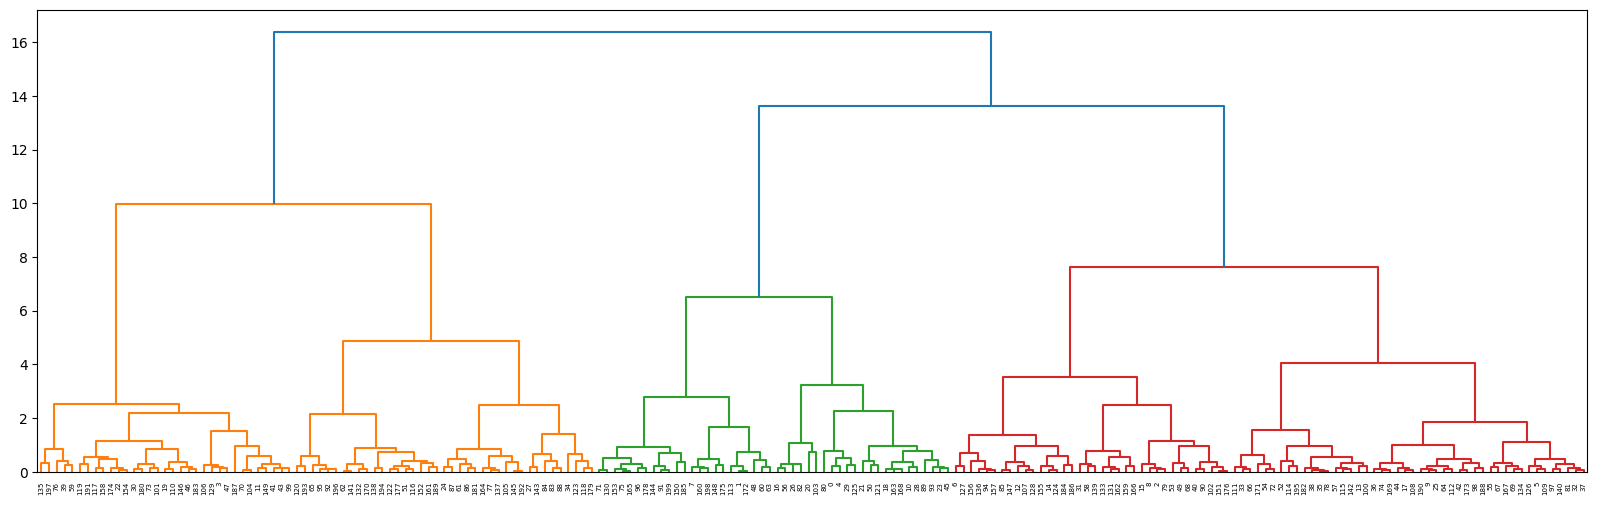

In [6]:
data = linkage(x,method='ward',metric='euclidean')
plt.figure(figsize=(20,6))
dendrogram(data)
plt.show()

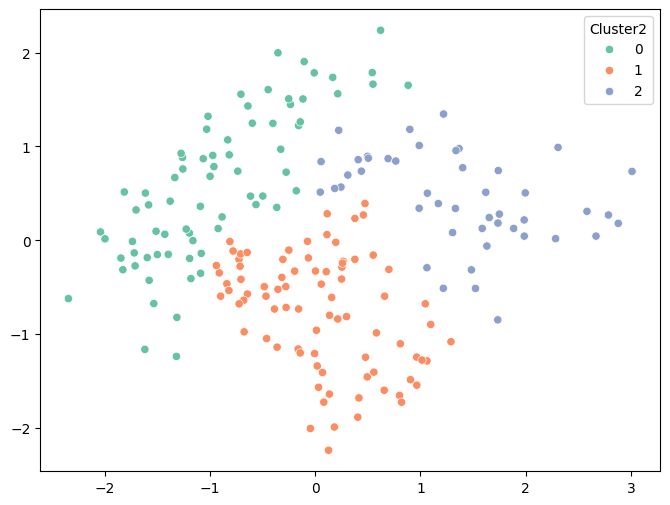

          Distance  Delivery_Person_Experience  Restaurant_Rating  \
Cluster2                                                            
0        -0.129534                   -0.167388           3.670833   
1         0.182481                    0.131386           3.757317   
2        -0.122543                    0.027788           3.810870   

          Customer_Rating  Delivery_Time  Order_Cost  Tip_Amount  \
Cluster2                                                           
0                3.655556       1.061257    0.040428   44.209306   
1                3.704878      -0.573410   -0.036947   49.380854   
2                3.702174      -0.638934    0.002582   45.457174   

          Weather_Conditions_Cloudy  Weather_Conditions_Rainy  \
Cluster2                                                        
0                          0.250000                  0.319444   
1                          0.207317                  0.256098   
2                          0.152174                  

In [7]:
a_clustering = AgglomerativeClustering(n_clusters=3,metric='euclidean',linkage='ward')
df['Cluster2'] = a_clustering.fit_predict(x)
plt.figure(figsize=(8,6))
sb.scatterplot(x=x[:,0],y=x[:,1],hue=df['Cluster2'],palette='Set2')
plt.show()
cluster_summary = df.groupby('Cluster2').mean(numeric_only=True)
print(cluster_summary)

# Summary of Phase 2
In this assignment KMeans and Agglomerative clustering is used to cluster the dataset based on Traffic condition, Weather condition, Delivery Time, Geographic Distance. For KMeans elbow method is used and ``4`` clusters have been made. For Agglomerative ``3`` clusters is made. Both of them have done a great work in creating clusters. But KMeans clustering seems to have better boundary.

In [8]:
df['Delivery_Status'] = df['Delivery_Time'].apply(lambda x: 'Fast' if x <= df['Delivery_Time'].quantile(0.5) else 'Delayed')
df['Delivery_Status'] = df['Delivery_Status'].map({'Fast': 0, 'Delayed': 1})
x = df[['GDistance','Weather_Conditions_Sunny','Weather_Conditions_Rainy','Weather_Conditions_Cloudy','Weather_Conditions_Snowy','Traffic_Conditions_High','Traffic_Conditions_Low','Traffic_Conditions_Medium','Order_Priority_High','Order_Priority_Low','Order_Priority_Medium']]
y = df['Delivery_Status']
x_train, x_test, y_train, y_test = tts(x, y, test_size=0.2, random_state=42)

In [9]:
model = keras.Sequential([
        keras.layers.Dense(1,activation='sigmoid')
])
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.fit(x_train,y_train,epochs=5)
y_pred1 = (model.predict(x_test) > 0.4).astype("int32")

Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5885 - loss: 0.7082  
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5724 - loss: 0.7273 
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5698 - loss: 0.7303 
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5612 - loss: 0.7543 
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5577 - loss: 0.7175 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


In [10]:
print(accuracy_score(y_test,y_pred1))
print(precision_score(y_test,y_pred1))
print(recall_score(y_test,y_pred1))
print(f1_score(y_test,y_pred1))

0.6
0.5806451612903226
0.8571428571428571
0.6923076923076923


In [11]:
model = keras.Sequential([
        keras.layers.Dense(100,activation='relu'),
        keras.layers.Dense(40,activation='relu'),
        keras.layers.Dense(1,activation='sigmoid')
])
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.fit(x_train,y_train,epochs=5)
y_pred2 = (model.predict(x_test) > 0.4).astype("int32")

Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5416 - loss: 0.6976
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5646 - loss: 0.6811 
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4805 - loss: 0.6873 
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6215 - loss: 0.6751 
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6358 - loss: 0.6673 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


In [12]:
print(accuracy_score(y_test,y_pred2))
print(precision_score(y_test,y_pred2))
print(recall_score(y_test,y_pred2))
print(f1_score(y_test,y_pred2))

0.575
0.5526315789473685
1.0
0.711864406779661


# Phase 3
In this model, neural networking is used to predict delivery status using Geographic Distance, Traffic Condition, Weather Condition and Order Priority.
Accuracy obtained using this model is not constant. In one of the run scores are;

## One Layer Model
1. Accuracy Score: 0.425
2. Precision Score: 0.4666666666666667
3. Recall Score: 0.6666666666666666
4. F1 Score: 0.5490196078431373

## Multilayer Model
1. Accuracy Score: 0.575
2. Precision Score: 0.5526315789473685
3. Recall Score: 1.0
4. F1 Score: 0.711864406779661

On an average, simple model's accuracy is in between 40 to 50 and multilayer model's accuracy is in between 50 to 60. As expected most of the time, multilayer model is more accurate than single layer model. But exceptions can be found. Both models has better accuracy than Logistic Model (Some scenerios were even better than other models).